# Warming of butter
How long does it take to get spreadable butter after taking it from refrigerator?

## Build the model
To answer this question, we build a model of the heat exchange between a block of butter and its surroundings.
The model uses a lumped parameter approach. We start with a description of the geometry. We use a body assembly that contains a cuboid volume and a heat exchange surface that includes all faces of the cuboid.

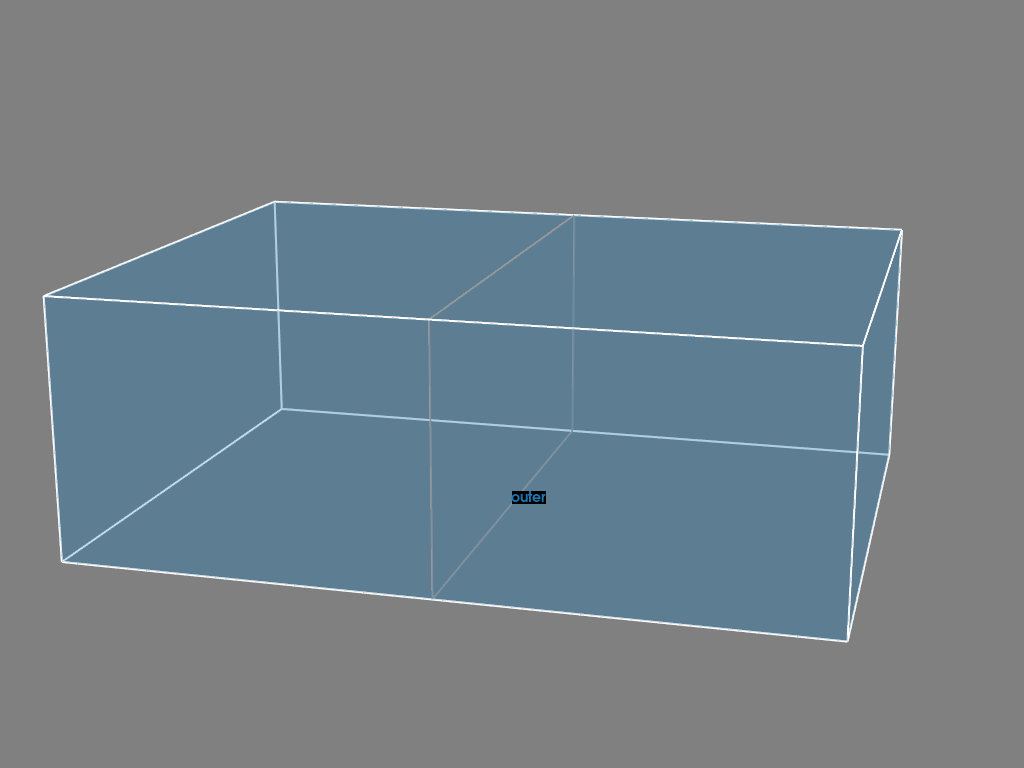

In [1]:
import pyvista as pv
pv.set_jupyter_backend('static')  # 'trame' for interactive 3d plots 

from thermca import *

width = .1
hgt = .035
depth = .075

with Asm() as asm:
    cube = Cube(
        width=width, 
        hgt=hgt, 
        depth=depth,
        width_div=2,
    )
    face = cube.face
    Surf(
        name='outer',
        faces=[face.left, face.right, face.btm, face.top, face.back, face.front]
    )

def show_thight(plot):
    plot.camera.zoom(1.25)
    plot.show()
    
show_thight(asm.plot())

Based on geometry we create a lumped parameter block made of salted butter. The butter material can be found in the solids material library.

In [2]:
with Model() as model:  
    butter = LPPart(
        asm=asm,
        matl=solids.salted_butter,
        init_temp=10.,
        name='butter'
    )

The butter in the kitchen is heated by convection and thermal radiation. The convection is caused by the surrounding air and the radiation is caused by the surrounding surfaces. The air and the surfaces are modelled as an environment point node element at constant temperature. The air is coupled to the butter surfaces by a film coefficient. The film coefficient represents the combined heat transfer by convection and radiation.

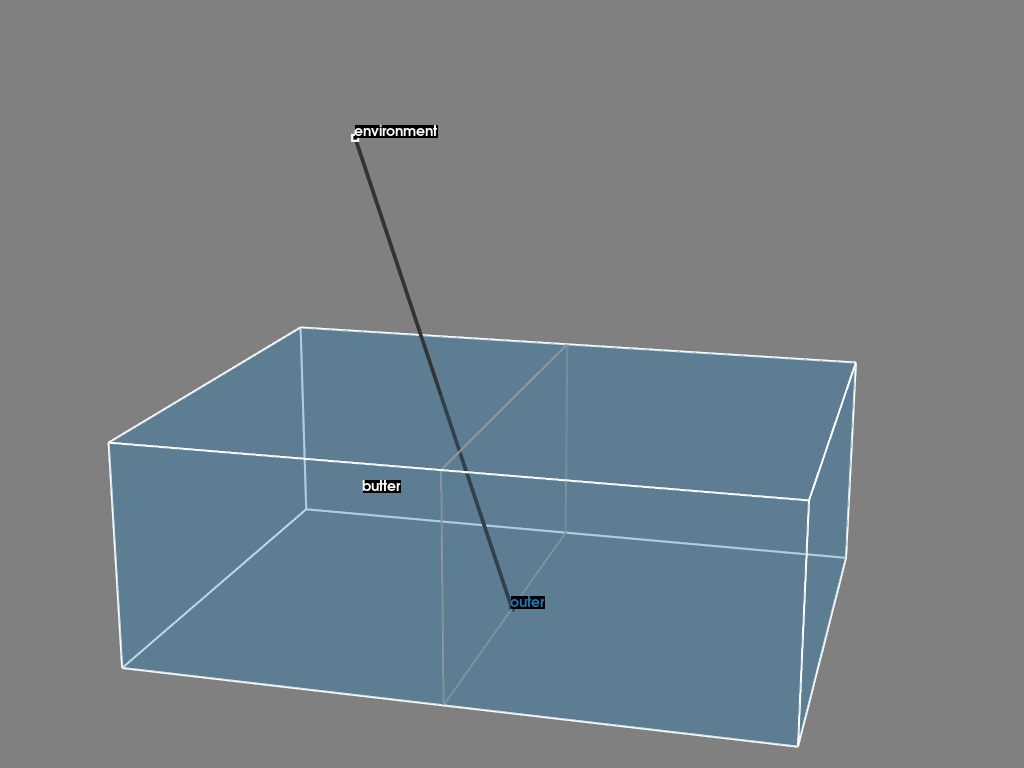

In [3]:
with model:   
    env = BoundNode(
        posn=(.025, .075, .0375),
        temp=20.,
        name='environment',
    )
    FilmLink(
        butter.surf.outer,
        env,
        film=combd_film.conv_radn_room_at_room_temps()
    )
show_thight(model.plot())

## Create a runnable node net
To run the model we transform it to an excecutable Network. The Network-plot shows the lumped parameters as symbols. The capacities as spheres and the conductances as cylinders. The size of the symbols scale with the values of the parameters. The bound temperature of the environment is drawn as six connected cones.

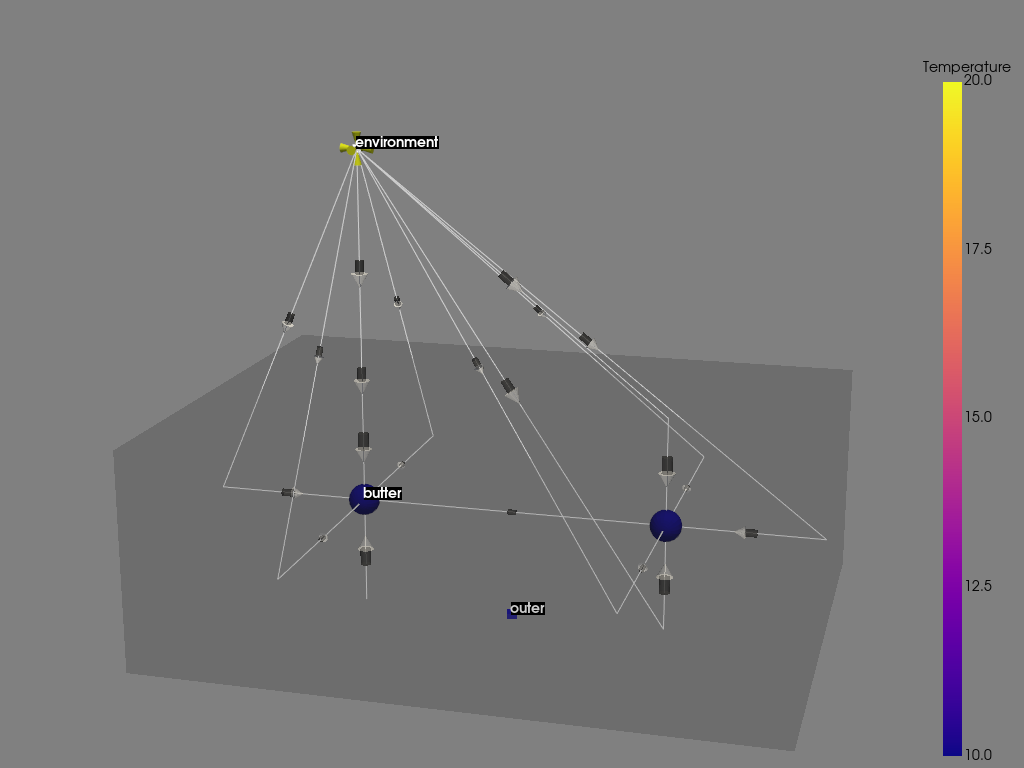

In [4]:
net20 = Network(model)
show_thight(net20.plot())

## Run the model
To simulate the warming over time we run it with the sim method.

We investigate the dependence of environment temperatures. Therefore, the warming is simulated twice, with ambient temperatures of 20°C and 35°C.

In [5]:
sim_time = 60*60*3
env.temp = 20.
net20 = Network(model)
result_20_deg = net20.sim([0., sim_time])
env.temp = 35.
net35 = Network(model)
result_35_deg = net35.sim([0., sim_time])

Simulation run progress, speed as sim. time vs. real time:
 0% 100% done.
Simulation run progress, speed as sim. time vs. real time:
 0% 100% done.


## Simulation results
As can be seen in the figure below, the resulting long warming times don't correspond with our real world experience. Something must be wrong. If we inspect the node net visualisation above, the size of the cylinders of the inner butter conductance and the conductance of the heat transfer to the environment is in the same same order of magnitude. This means a slow warming of the butter with high temperature differences inside the butter can be expected. Therefore, we have to improve our model.

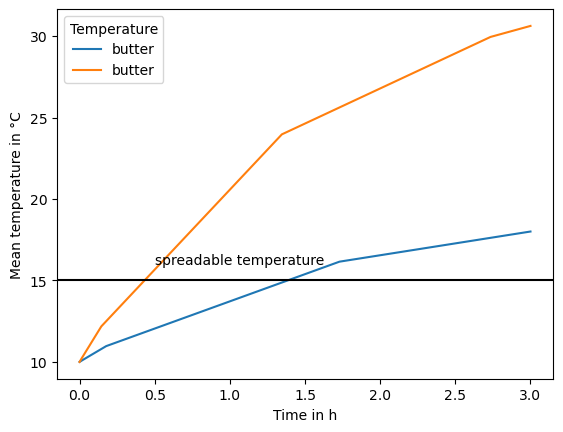

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
butter_20 = result_20_deg[butter].temp_frame()
butter_35 = result_35_deg[butter].temp_frame()
butter_temps = pd.concat([butter_20, butter_35], axis=1)
butter_temps = butter_temps.sort_index().interpolate('index')
butter_temps.index /= 60*60
butter_temps.index.name = 'Time in h'
butter_temps.plot()
plt.ylabel('Mean temperature in °C')
plt.axhline(y=15, color='k')
plt.text(.5, 16, 'spreadable temperature');

## Build model with higher spatial resolution
A higher spatial resolution of the butter is required to represent the temperature differences adequately. To minimise the resulting computational load, we simulate only one eighth of the axisymmetric butter. 

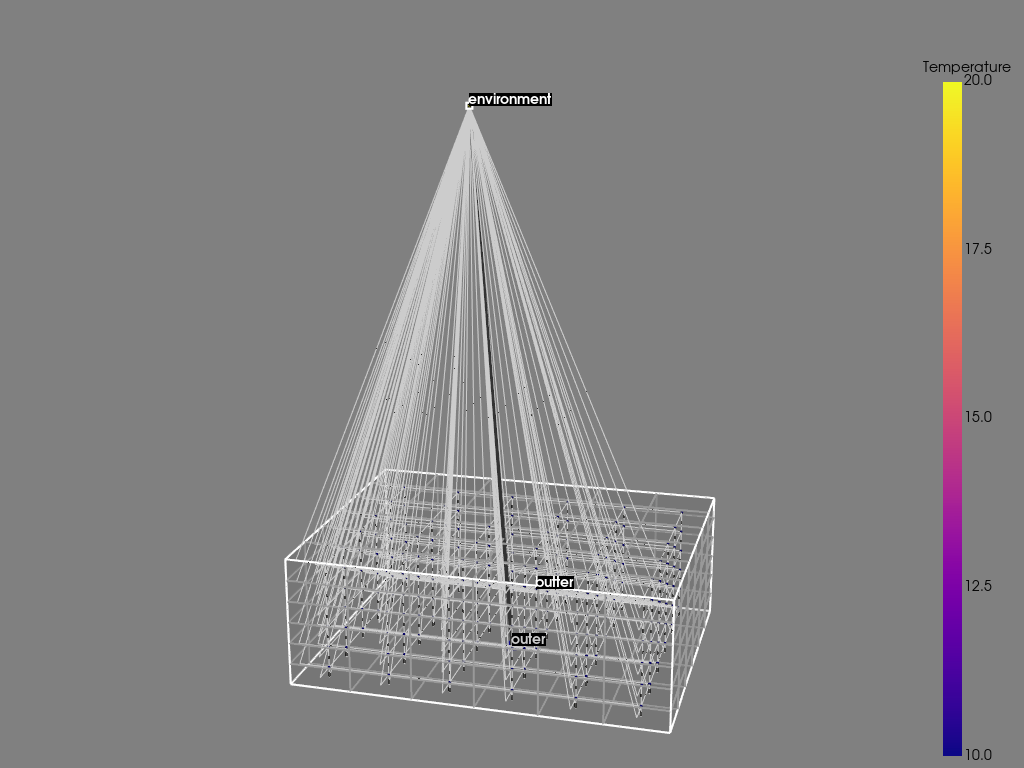

In [7]:
with Asm() as asm:
    cube = Cube(
        width=width/2, 
        hgt=hgt/2, 
        depth=depth/2,
        width_div=6, 
        hgt_div=6, 
        depth_div=6,
    )
    face = cube.face
    Surf(
        name='outer',
        faces=[face.left, face.btm, face.back]
    )
    
with Model() as model:  
    butter = LPPart(
        asm=asm,
        matl=solids.salted_butter,
        init_temp=10.,
        name='butter'
    )
    env = BoundNode(
        posn=(.025, .075, .0375),
        temp=20.,
        name='environment',
    )
    FilmLink(
        butter.surf.outer,
        env,
        film=combd_film.conv_radn_room_at_room_temps()
    )
    
net20 = Network(model)
net20.plot(hide=(HEAT, LUMP_NODE_IDX, AXES), geo_scale_type='area').show()

## Simulation and results
The figure below shows the temperatures at the surface corner of the butter block. The results are more realistic now. 

The final understanding of the simulation results is that butter warming is highly dependent on ambient temperature.

Simulation run progress, speed as sim. time vs. real time:
 0% 100% done.
Simulation run progress, speed as sim. time vs. real time:
 0% 100% done.


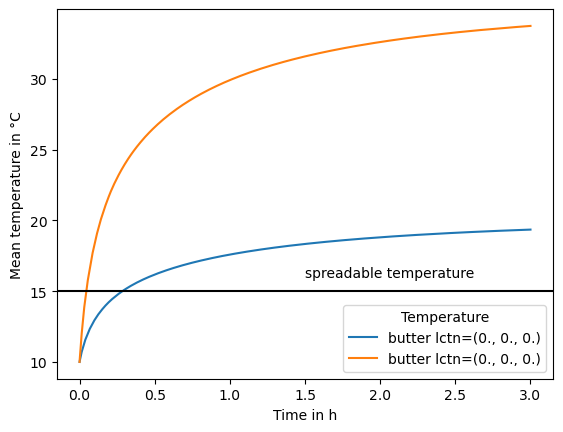

In [8]:
sim_time = 60*60*3
env.temp = 20.
net20 = Network(model)
result_20_deg = net20.sim([0., sim_time])
env.temp = 35.
net35 = Network(model)
result_35_deg = net35.sim([0., sim_time])

butter_20 = result_20_deg[butter].temp_frame(lctn=[(0., 0., 0.)])
butter_35 = result_35_deg[butter].temp_frame(lctn=[(0., 0., 0.)])
butter_temps = pd.concat([butter_20, butter_35], axis=1)
butter_temps = butter_temps.sort_index().interpolate('index')
butter_temps.index /= 60*60
butter_temps.index.name = 'Time in h'
butter_temps.plot()
plt.ylabel('Mean temperature in °C')
plt.axhline(y=15, color='k')
plt.text(1.5, 16, 'spreadable temperature');